In [24]:
%matplotlib inline
# --------------------------------------------------
#
# Cluster the Data using Agglomerative Clustering
#
# --------------------------------------------------


import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

class AgglomerativeClusterer():
    def __init__(self, filename='data/pills-s0.npy', N=10):
        self.filename = filename
        self.X = np.load(filename)
        self.idx = np.arange(self.X.shape[0])
        
        self.N = N
        self.event_labels  = {i:i for i in range(self.N)}
    
    def to_range(self, l, cmap):
        total = cmap.N
        idx = int((l[-1] / self.N) * total)
        return cmap(idx)

    def boundaries(self, v):
        bounds = [0] + list(np.where(v[:-1] != v[1:])[0] + 1) + [len(v)-1]
        return [(bounds[i], bounds[i+1], v[bounds[i]]) for i in range(len(bounds)-1)]
    
    def remap_labels(self, labels):
        map_keys = np.argsort(np.unique(labels, return_counts=True)[1]).reshape(self.N, 1)[::-1]
        vals, idx = np.where(labels == map_keys)
        labels[idx] = vals
        return labels
    
    def run_scipy_clustering(self, link_type='ward', affinity='euclidean', connectivity=None):
        Z = linkage(self.X, link_type)
        
        plt.figure(figsize=(25, 10))
        plt.title('Hierarhical Clustering Dendrogram')
        plt.xlabel('sample index')
        plt.ylabel('distance')
        dendrogram(
            Z,
            leaf_rotation=90.,
            leaf_font_size=8.,
        )
        plt.show()
    
    def run_clustering(self, link_type='ward', affinity='euclidean', connectivity=None):
        model = AgglomerativeClustering(linkage=link_type, affinity=affinity, n_clusters=self.N, connectivity=connectivity)
        
        start = time.time()
        model.fit(self.X)
        end = time.time()
        total_time = end - start
        
        model_labels = model.labels_
        labels = self.remap_labels(model_labels)
        return (affinity, link_type, total_time, np.unique(labels, return_counts=True), self.boundaries(model_labels), model_labels)
        
link_types = ('average', 'complete', 'ward')

ac = AgglomerativeClusterer()
results = ac.run_clustering()
print('total time:', results[2])
print('Labels:', results[5], results[3])
print('boundaries', len(results[4]))

for i, tp in enumerate(link_types):
    results = ac.run_clustering(link_type=tp)
    print(results[1], results[2])

total time: 0.5181026458740234
Labels: [2 2 2 ... 2 2 2] (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([2260,  950,  421,  344,  212,  134,   78,   57,   48,    2]))
boundaries 414
average 0.49155235290527344
complete 0.4299306869506836
ward 0.5699951648712158


In [16]:
# %matplotlib tk
%matplotlib inline
# --------------------------------------------------
#
# various affinity metrics
#
# --------------------------------------------------

link_types = ('average', 'complete')
affinities = ('euclidean', 'l1', 'l2', 'manhattan', 'cosine')

ac = AgglomerativeClusterer(N=8)

for j, aff in enumerate(affinities):
    for i, lt in enumerate(link_types):
        results = ac.run_clustering(link_type=lt, affinity=aff)
        print(results[0], results[1], results[2], results[3][1], (len(results[4]) + 1))

euclidean average 0.4214293956756592 [4472   23    6    1    1    1    1    1] 40
euclidean complete 0.4167943000793457 [3736  588   84   65   26    4    2    1] 280
l1 average 0.42769646644592285 [4480   16    5    1    1    1    1    1] 36
l1 complete 0.417248010635376 [4123  220  141   11    7    2    1    1] 197
l2 average 0.417757511138916 [4472   23    6    1    1    1    1    1] 40
l2 complete 0.41376352310180664 [3736  588   84   65   26    4    2    1] 280
manhattan average 0.4207892417907715 [4480   16    5    1    1    1    1    1] 36
manhattan complete 0.4118514060974121 [4123  220  141   11    7    2    1    1] 197
cosine average 0.44922852516174316 [3656  430  213  184   12    8    2    1] 230
cosine complete 0.5563244819641113 [3227  436  246  204  138   95   85   75] 543


In [22]:
%matplotlib tk
# %matplotlib inline
# --------------------------------------------------
#
# levels of connectivity
#
# --------------------------------------------------

link_types = ('complete', 'ward')
connectivities = (None, 10, 30, 100)
ac = AgglomerativeClusterer(N=8)

# compute connectiviy graphs
print('----------------------------')
print('computing connectivity graphs...')
t0 = time.time()
knn_graphs = {}
for k in connectivities:
    graph = None
    if k is not None:
        graph = kneighbors_graph(X, k, include_self=False)
    knn_graphs[k] = graph
elapsed_time = time.time() - t0
print('complete', elapsed_time)
print('----------------------------')


for j, k in enumerate(connectivities):
    for i, lt in enumerate(link_types):
        connectivity = knn_graphs[k]
        
        results = ac.run_clustering(link_type=lt, connectivity=connectivity)
        print(k, lt, results[2], results[3][1])

----------------------------
computing connectivity graphs...
complete 0.3395726680755615
----------------------------
None complete 0.41242384910583496 [3736  588   84   65   26    4    2    1]
None ward 0.6042506694793701 [2260  950  449  421  212  134   78    2]
10 complete 0.5769691467285156 [4495    4    2    1    1    1    1    1]
10 ward 0.32602763175964355 [2329 1033  391  283  196  138  134    2]
30 complete 1.138321876525879 [4491    6    4    1    1    1    1    1]
30 ward 1.0476760864257812 [2260  950  449  421  212  134   78    2]
100 complete 2.392587900161743 [4479   11    8    4    1    1    1    1]
100 ward 2.9382832050323486 [2260  950  449  421  212  134   78    2]


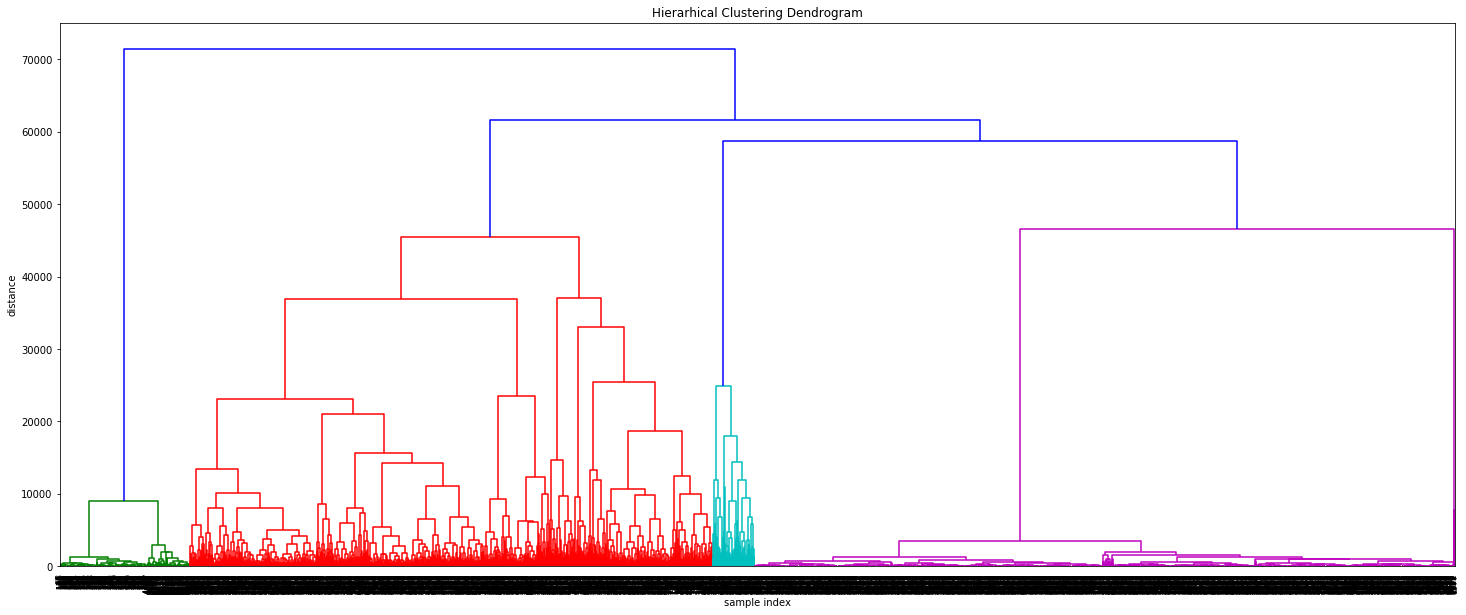

In [25]:
ac = AgglomerativeClusterer()
ac.run_scipy_clustering()